I did this a bit flippantly before, but I want to fomalize the process by which we estimate the uncertainty on emulator predictions. 

In [63]:
from pearce.emulator import SpicyBuffalo, LemonPepperWet
from pearce.mocks import cat_dict
import numpy as np
from os import path

In [64]:
import matplotlib
#matplotlib.use('Agg')
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [65]:
#xi gg
training_file = '/scratch/users/swmclau2/xi_zheng07_cosmo_lowmsat/PearceRedMagicXiCosmoFixedNd.hdf5'
#test_file= '/scratch/users/swmclau2/xi_zheng07_cosmo_test_lowmsat2/'
test_file =  '/scratch/users/swmclau2/xi_zheng07_cosmo_test_lowmsat2/PearceRedMagicXiCosmoFixedNd_Test.hdf5'

In [66]:
em_method = 'gp'
split_method = 'random'

In [67]:
a = 1.0
z = 1.0/a - 1.0

In [68]:
fixed_params = {'z':z}#, 'cosmo': 0}#, 'r':24.06822623}

In [69]:
from glob import glob

In [70]:
hp = []
for fname in sorted(glob('/home/users/swmclau2/Git/pearce/bin/optimization/sloppy_joes_indiv_bins/sloppy*.npy')):
    #print fname, len(hp)
    hp.append(np.loadtxt(fname))

In [71]:
len(hp)

18

In [72]:
param_names = ['ombh2', 'omch2', 'w0', 'ns', 'ln10As', 'H0', 'Neff', 'logM0', 'sigma_logM', 'logM1', 'alpha']

In [73]:
pnames = ['bias', 'amp']
pnames.extend(param_names)
pnames.append('amp')
pnames.extend(param_names)

In [74]:
from collections import defaultdict
metric = []

for _hp in hp:
    metric.append(defaultdict(list))
    for val, pname in zip(_hp, pnames):
        metric[-1][pname].append(val)

In [75]:
np.random.seed(0)
emu = LemonPepperWet(training_file, method = em_method, fixed_params=fixed_params,
                 custom_mean_function = None, downsample_factor = 0.1)#, hyperparams = {'metric':metric})

In [76]:
emu.get_param_names()

['ombh2',
 'omch2',
 'w0',
 'ns',
 'ln10As',
 'H0',
 'Neff',
 'logM0',
 'sigma_logM',
 'logM1',
 'alpha']

In [77]:
pred_y, data_y = emu.goodness_of_fit(test_file, statistic = None)

In [78]:
print len(pred_y[0])

35000


In [79]:
test_x, _, test_err, _ = emu.get_data(test_file, emu.fixed_params)

t, old_idxs  = emu._whiten(test_x)

In [80]:
train_x, train_y, train_err, info = emu.get_data(training_file, emu.fixed_params)

/home/users/swmclau2/.local/lib/python2.7/site-packages/pearce/emulator/emu.py:294: UserWarning: WARNING: NaN detected. Skipped 21 points in training data.
  warnings.warn('WARNING: NaN detected. Skipped %d points in training data.' % (num_skipped))


In [81]:
len(train_err)

40000

In [82]:
mean_func_at_params = emu.mean_function(t)

In [83]:
mean_func_at_params.shape

(18,)

In [84]:
plt_idx = 4249
print t[0][plt_idx]
print pred_y[0][plt_idx]
print data_y[0][plt_idx]
#print mean_func_at_params[0][plt_idx]

[ 1.33619946 -1.41073566  1.2937706   1.09007699 -0.99425337 -1.29157473
 -1.01915118 -0.62179221 -0.20608562  0.74996107 -0.50398343]
3.86065096638
3.99002394681


In [85]:
resmat = np.zeros(( 7, 5, 1000, 18))
resmat_log = np.zeros_like(resmat)
predmat = np.zeros(( 7, 5, 1000, 18))

datamat = np.zeros(( 7, 5, 1000, 18))

for bin_no in xrange(len(pred_y)):
    py, dy = pred_y[bin_no], data_y[bin_no]
    for cosmo_no in xrange(7):
        cpy, cdy = py[cosmo_no*5000:(cosmo_no+1)*5000], dy[cosmo_no*5000:(cosmo_no+1)*5000]
        #for realization_no in xrange(5):
        for hod_no in xrange(1000):
            crpy, crdy = cpy[hod_no::1000], cdy[hod_no::1000]

            #for hod_no in xrange(1000):
            #print crpy.std()
            predmat[cosmo_no, :,  hod_no , bin_no] = crpy
            datamat[cosmo_no, :,  hod_no , bin_no] = crdy
            resmat[cosmo_no, :,  hod_no , bin_no] = 10**crpy - 10**crdy
            resmat_log[cosmo_no, :,  hod_no , bin_no] = crpy - crdy

In [86]:
resmat.shape

(7, 5, 1000, 18)

(18, 5)


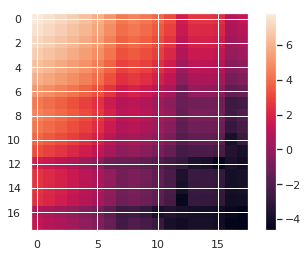

(18, 5)


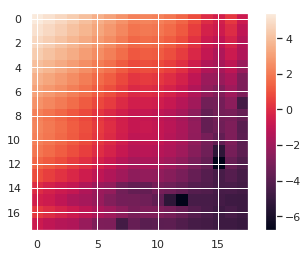

(18, 5)


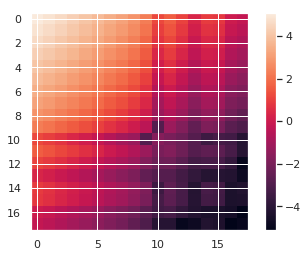

(18, 5)


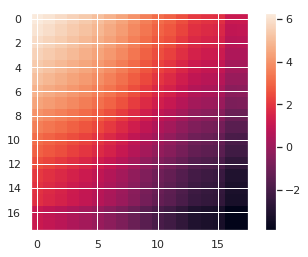

(18, 5)


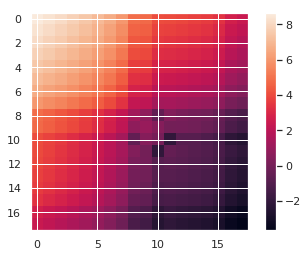

In [87]:
N = 5
for cosmo_no in xrange(7):
    for hod_no in xrange(1000):
        r = resmat[cosmo_no, :, hod_no].reshape((-1, 18), order = 'C').T
        print r.shape
        scovmat = r.dot(r.T)/r.shape[1]
        #fig = plt.figure(figsize = (10, 6))
        #plt.subplot(121)
        im = plt.imshow(np.log10(np.abs(scovmat) ))
        plt.colorbar(im)
        #plt.subplot(122)
        #pred = 10**predmat[cosmo_no, :, hod_no].reshape((-1, 18), order = 'C').T
        #print pred.shape
        #data = datamat[cosmo_no, :, hod_no].reshape((-1, 18), order = 'C').T
        #scovmat2 = np.cov(pred)
        #im = plt.imshow(np.log10(np.abs(scovmat2) ), cmap = 'viridis', vmin = -5,vmax = 9)
        #plt.colorbar(im)
        
        plt.show()
        N-=1
        
        if N == 0:
            break
    if N==0:
        break

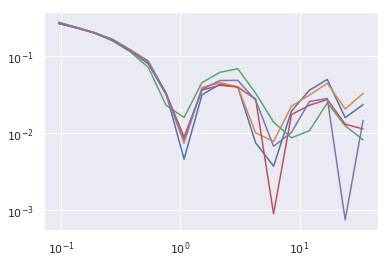

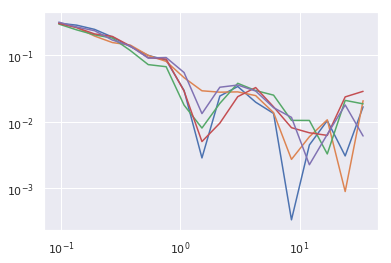

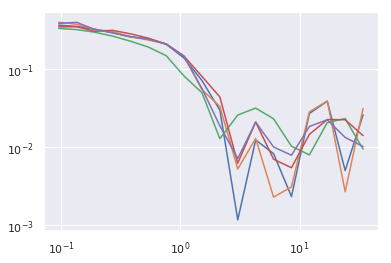

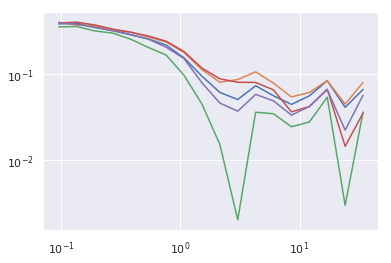

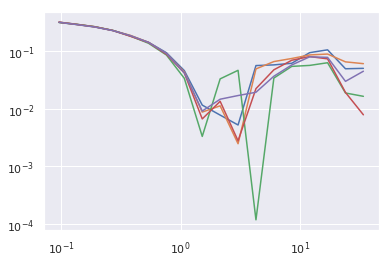

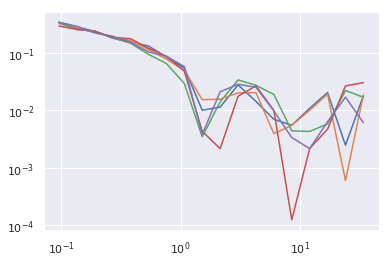

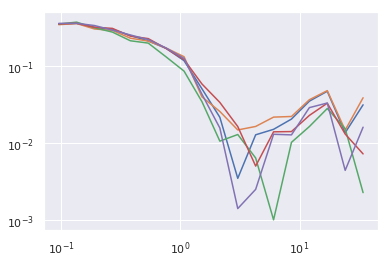

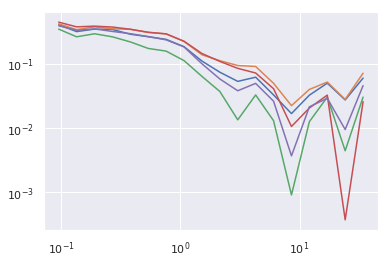

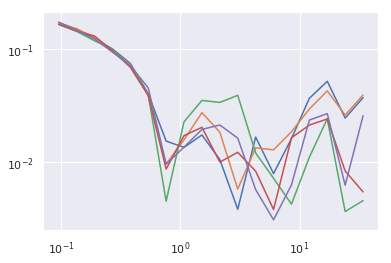

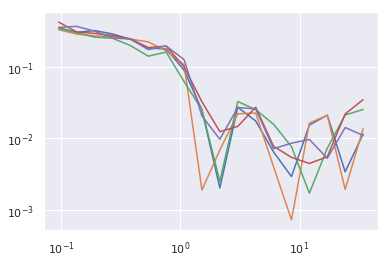

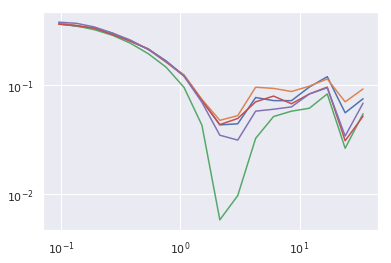

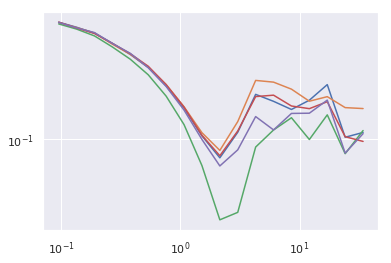

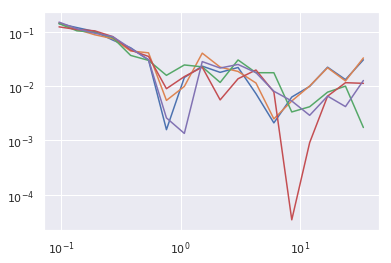

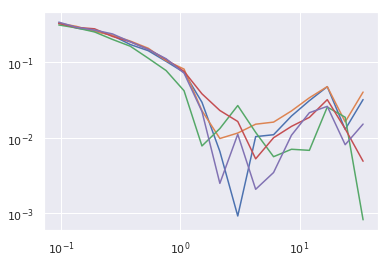

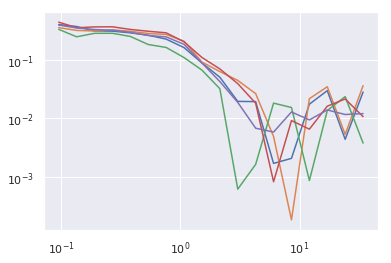

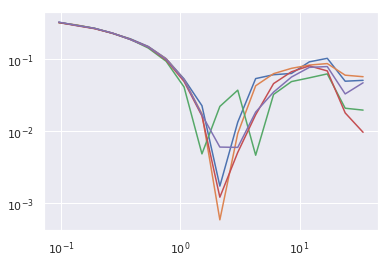

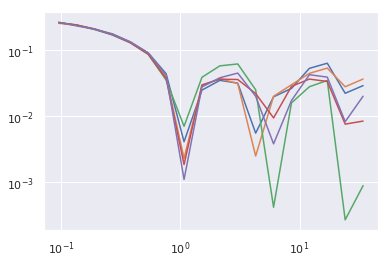

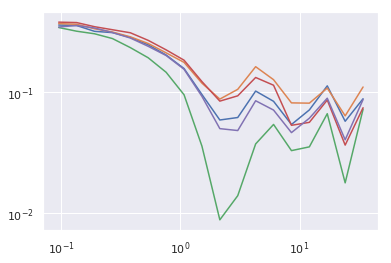

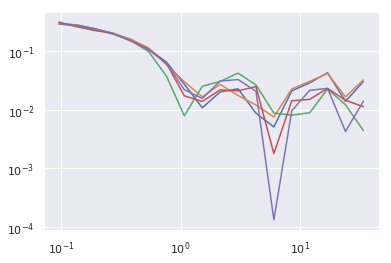

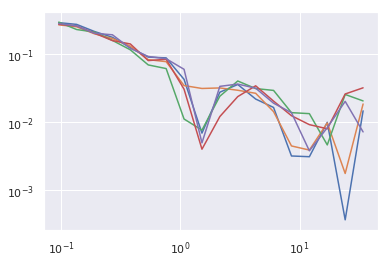

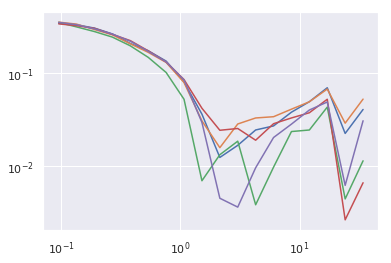

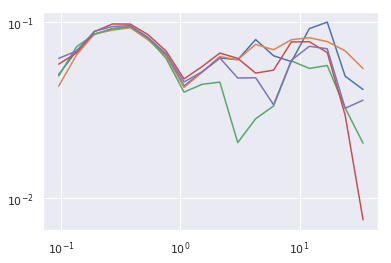

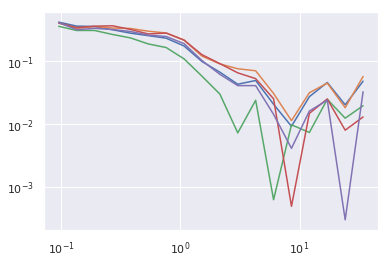

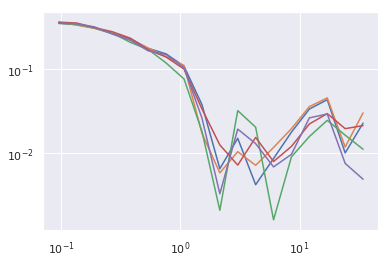

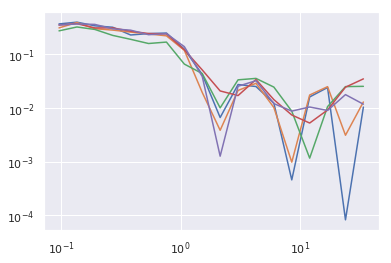

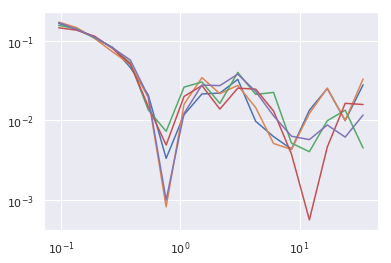

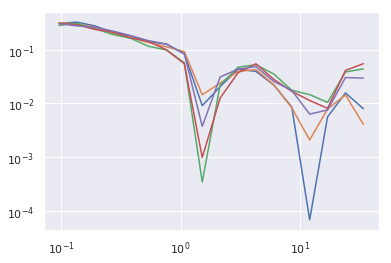

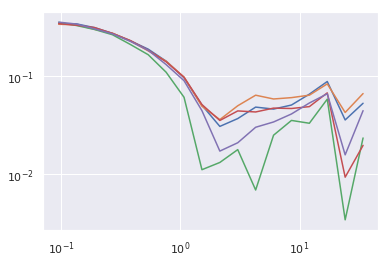

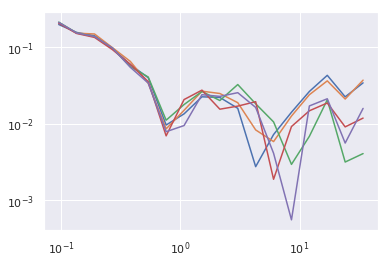

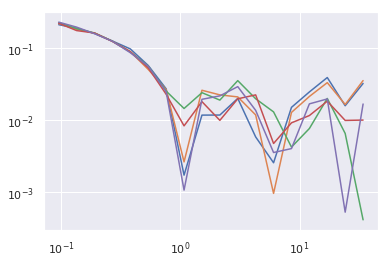

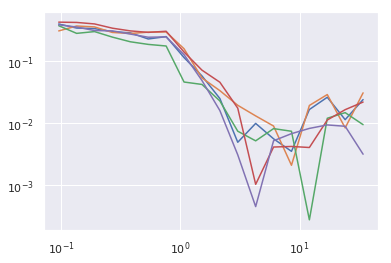

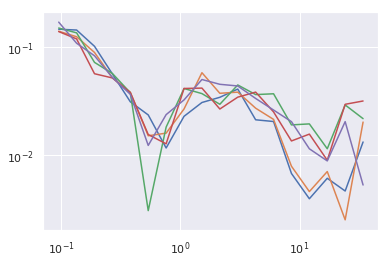

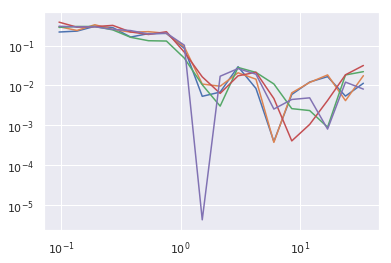

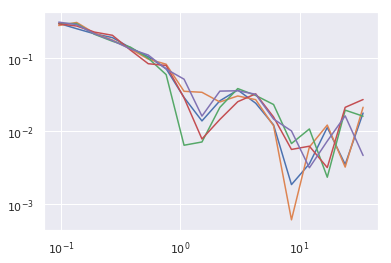

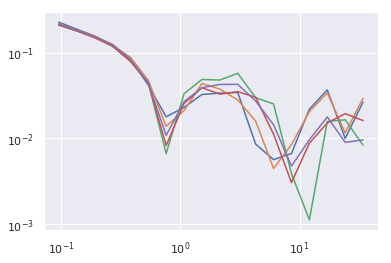

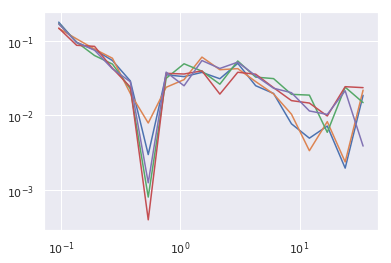

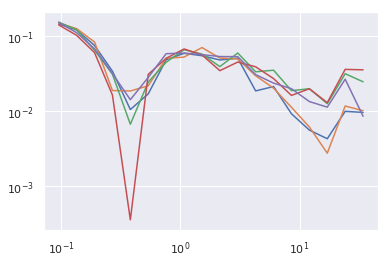

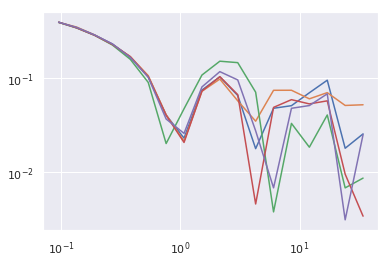

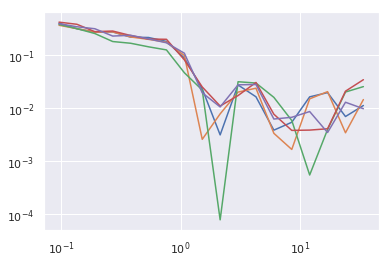

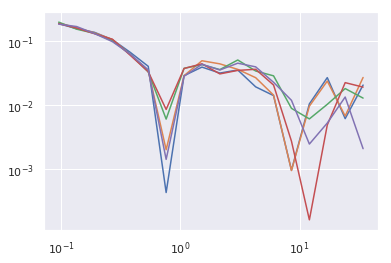

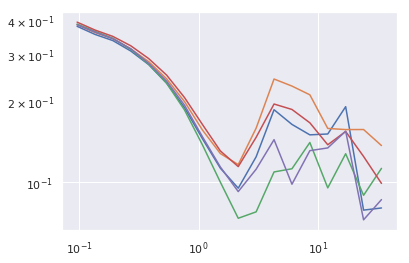

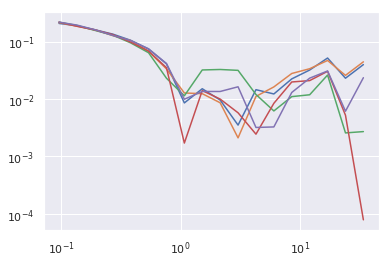

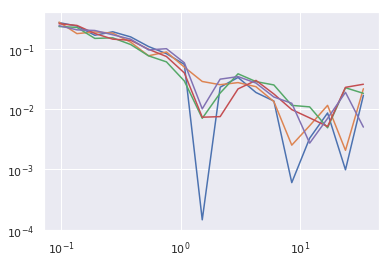

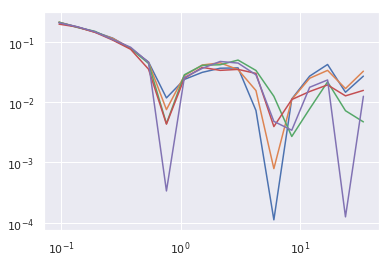

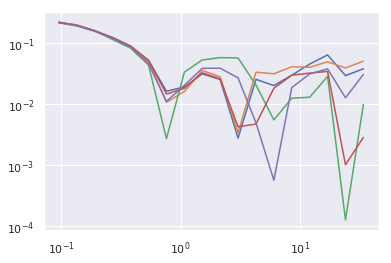

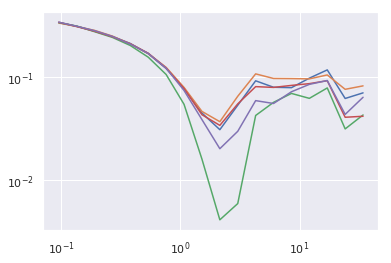

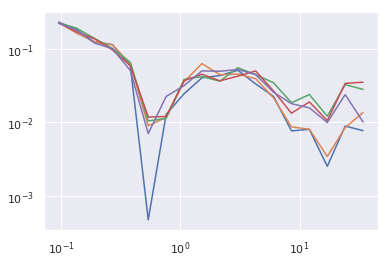

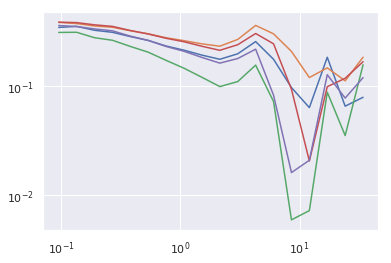

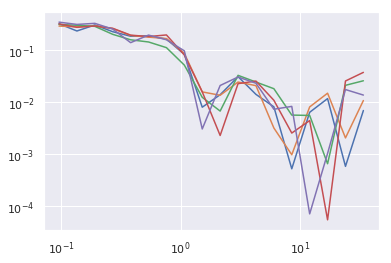

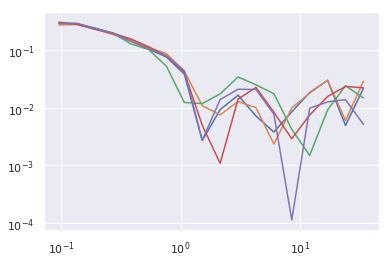

In [88]:
N = 50
for cosmo_no in xrange(7):
    for hod_no in xrange(1000):
        
        pred = 10**predmat[cosmo_no, :, hod_no].reshape((-1, 18), order = 'C')
        data = 10**datamat[cosmo_no, :, hod_no].reshape((-1, 18), order = 'C')
        for p,d in zip(pred,data):
            plt.plot(emu.scale_bin_centers, np.abs(p-d)/d)
        #for d in data:
        #    plt.plot(emu.scale_bin_centers, d)
        
        plt.xscale('log')
        plt.yscale('log')
        plt.show()
        N-=1
        
        if N == 0:
            break
    if N==0:
        break

In [89]:
resmat_flat = resmat.reshape((-1, 18)).T
datamat_flat = datamat.reshape((-1, 18)).T
#resmat_hodrealav = np.mean(resmat_realav, axis = 1)

In [90]:
r_idx = 10
t_bin = t[r_idx]
acc_bin = np.abs(resmat_flat[r_idx])/datamat_flat[r_idx]

In [91]:
t_bin.shape, acc_bin.shape

((35000, 11), (35000,))

In [92]:
percentiles = np.percentile(acc_bin, range(101))
norm_acc_bin = np.digitize(acc_bin, percentiles)
#norm_acc_bin = 100*((acc_bin - acc_bin.min())/acc_bin.max()).astype(int)

In [93]:
palette = sns.diverging_palette(220, 20, n=len(percentiles)-1, as_cmap=True)
#sns.set_palette(palette)

In [94]:
pnames = emu.get_param_names()

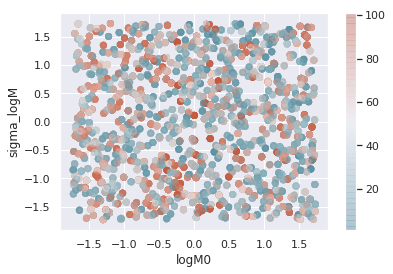

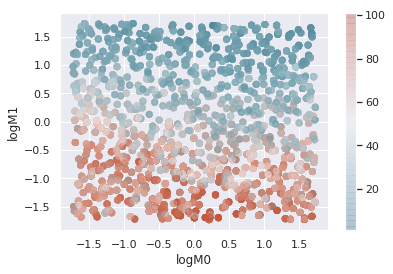

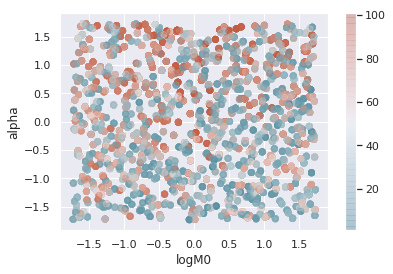

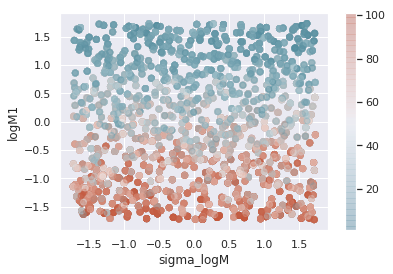

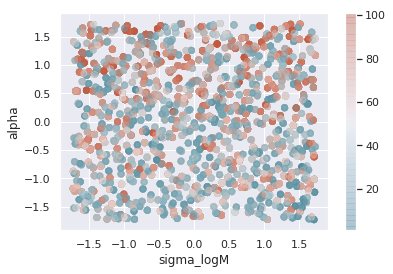

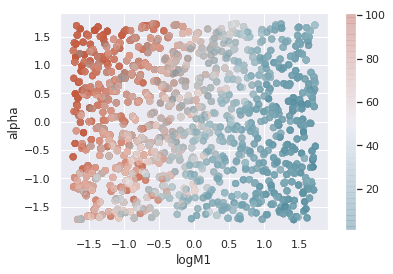

In [95]:
for axes1 in xrange(7,11):
    for axes2 in xrange(axes1+1, 11):
        cbar = plt.scatter(t_bin[:,axes1 ], t_bin[:,axes2], c = norm_acc_bin,cmap = palette, alpha = 0.2)
        plt.colorbar(cbar)
        plt.xlabel(pnames[axes1])
        plt.ylabel(pnames[axes2])
        #plt.gray()
        plt.show()

In [96]:
test_err_bin = test_err[:, r_idx, r_idx]

(array([   21.,   136.,   635.,  2505.,  6071.,  9794.,  9807.,  4954.,
          997.,    80.]),
 array([-6.4880701 , -6.23495877, -5.98184744, -5.72873611, -5.47562478,
        -5.22251345, -4.96940212, -4.71629079, -4.46317947, -4.21006814,
        -3.95695681]),
 <a list of 10 Patch objects>)

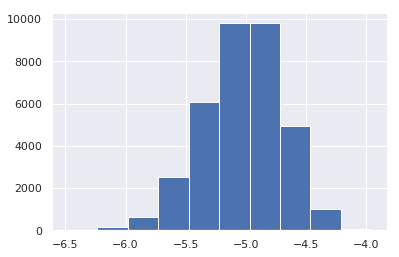

In [97]:
plt.hist(np.log10(test_err_bin) )

# Why are these different?

(array([   164.,   2085.,   8315.,  10257.,   8919.,   5685.,   2963.,
          1287.,    289.,     36.]),
 array([-1.41924799, -1.30072147, -1.18219495, -1.06366842, -0.9451419 ,
        -0.82661538, -0.70808885, -0.58956233, -0.47103581, -0.35250928,
        -0.23398276]),
 <a list of 10 Patch objects>)

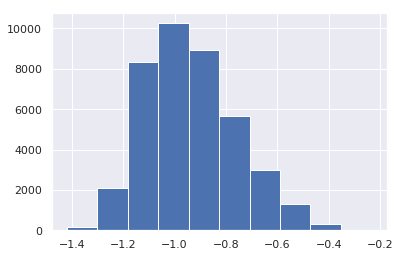

In [98]:
plt.hist(np.log10(np.sqrt(emu.yerr[r_idx])) )

In [99]:
len(emu.yerr)

18

In [100]:
percentiles = np.percentile(np.log10(test_err_bin), [0, 10,20,30,40,50,60,70,80,90,100])
norm_err_bin = np.digitize(np.log10(test_err_bin), percentiles)

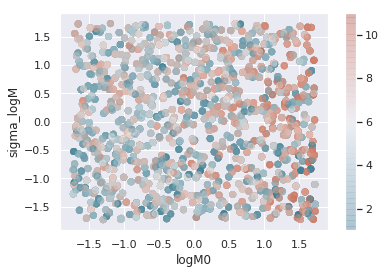

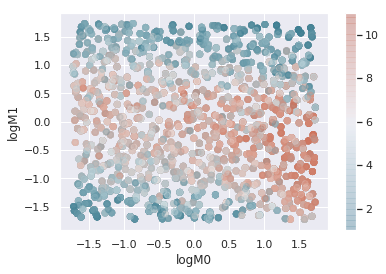

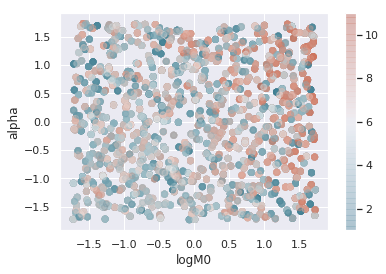

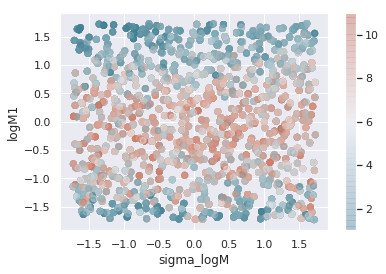

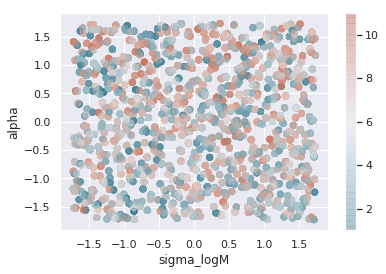

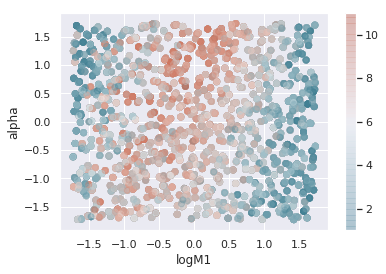

In [101]:
#relevant stat is uncertainty in training error, not test error
for axes1 in xrange(7,11):
    for axes2 in xrange(axes1+1, 11):
        cbar = plt.scatter(t_bin[:,axes1 ], t_bin[:,axes2], c = norm_err_bin,cmap = palette, alpha = 0.2)
        plt.colorbar(cbar)
        plt.xlabel(pnames[axes1])
        plt.ylabel(pnames[axes2])
        #plt.gray()
        plt.show()

In [102]:
test_err_diag= np.array([test_err[:, r_idx, r_idx] for r_idx in xrange(emu.n_bins)] )

In [103]:
test_err_diag.mean(axis = 1)

array([  6.66416262e-04,   3.90266113e-04,   2.40298112e-04,
         1.59608324e-04,   1.11817891e-04,   8.52685284e-05,
         6.85463332e-05,   3.27251532e-05,   1.61159551e-05,
         1.23840494e-05,   1.22300077e-05,   1.20386761e-05,
         8.81174492e-06,   6.19478076e-06,   5.05835371e-06,
         4.66060676e-06,   5.20829565e-06,   7.42500106e-06])

In [112]:
np.sqrt(np.mean(np.square(np.abs(resmat_flat)/(10**datamat_flat) )))

0.084350297620042369

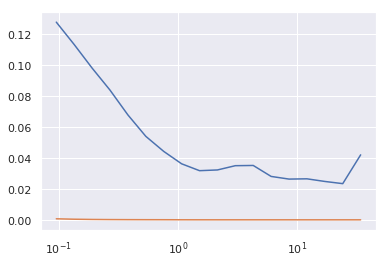

In [104]:
plt.plot(emu.scale_bin_centers, np.mean(np.abs(resmat_flat)/(10**datamat_flat), axis = 1) )
plt.plot(emu.scale_bin_centers, np.mean(np.abs(test_err_diag), axis = 1) )

plt.xscale('log')

In [105]:
resmat_log_flat = resmat_log.reshape((-1, 18)).T

In [106]:
np.mean(np.array([ye/np.abs(y+1e-9) for ye, y in zip(emu.yerr, emu.y)]) , axis = 1)

array([  6.88971478e+02,   6.13597662e-03,   6.64106546e-03,
         7.28736319e-03,   8.16241541e-03,   9.42955257e-03,
         7.25344587e+01,   1.10902183e-02,   1.14167158e-02,
         1.31384973e-02,   1.63399965e-02,   2.17118471e-02,
         3.10878552e-02,   5.23228689e-02,   2.06445287e-01,
         8.96476256e-01,   1.11314614e-01,   3.06048094e-02])

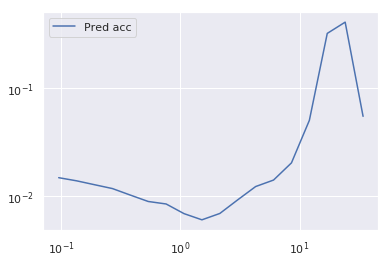

In [107]:
plt.plot(emu.scale_bin_centers, np.mean(np.abs(resmat_log_flat)/np.abs(datamat_flat), axis = 1), label = 'Pred acc' )
#plt.plot(emu.scale_bin_centers, np.mean(np.array([ye/np.abs(y+1e-9) for ye, y in zip(emu.yerr, emu.y)]), axis = 1), label = 'Training Err' )
plt.yscale('log')
plt.legend(loc ='best')
plt.xscale('log')

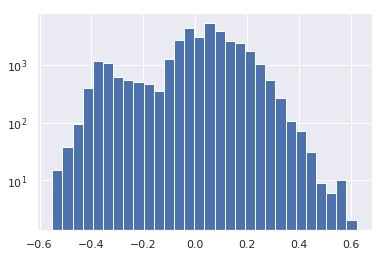

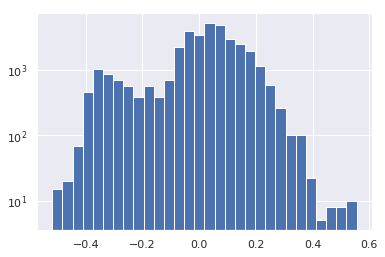

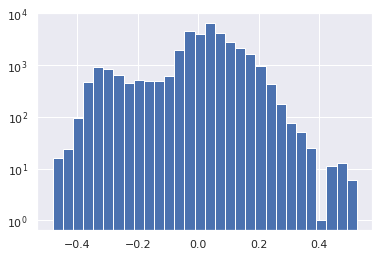

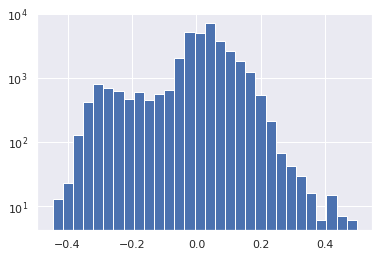

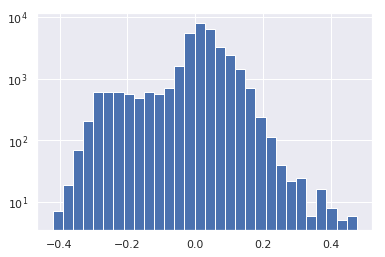

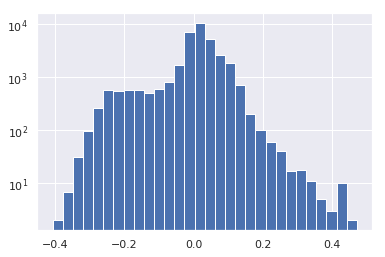

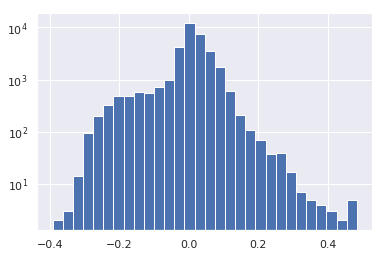

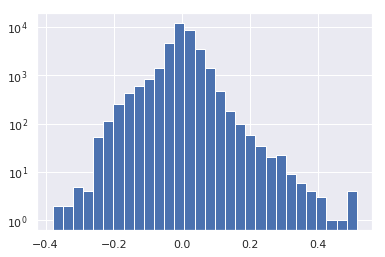

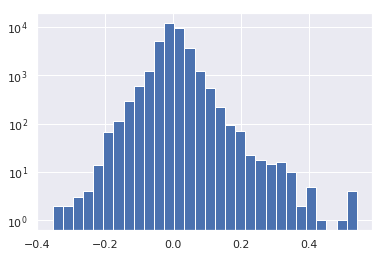

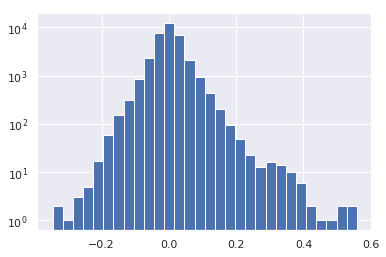

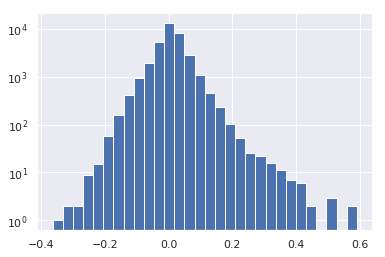

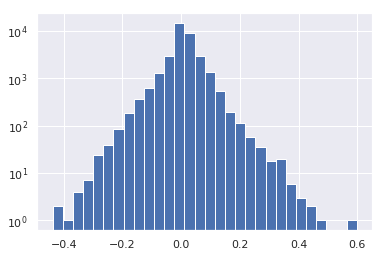

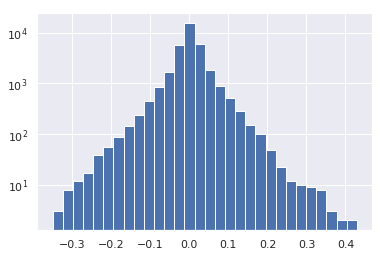

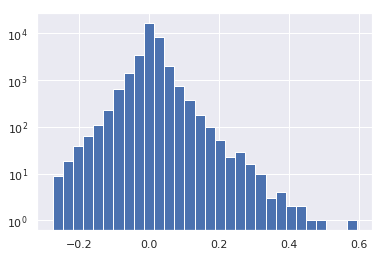

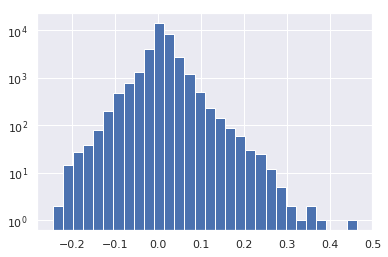

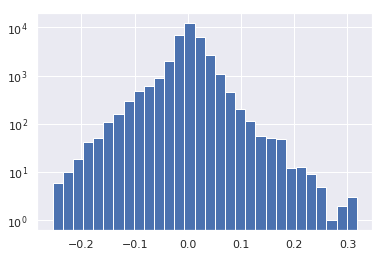

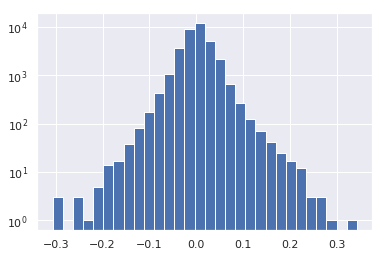

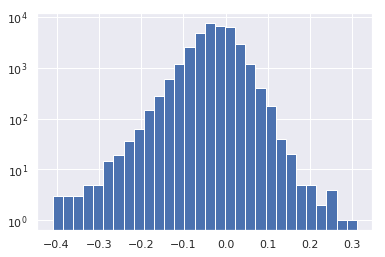

In [108]:
for res, dat in zip(resmat_flat, 10**datamat_flat):
    plt.hist(res/dat, bins = 30)#, bins = np.linspace(-1, 1, 30))
    plt.yscale('log')
    plt.show()


In [109]:
scovmat = resmat_flat.dot(resmat_flat.T)/(len(pred_y[0])-1)

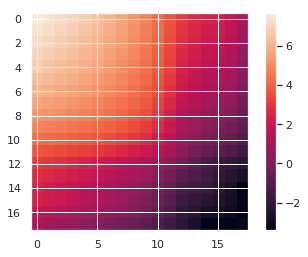

In [110]:
im = plt.imshow(np.log10(scovmat) )
plt.colorbar(im)
plt.show()

In [111]:
print np.sqrt(np.diag(scovmat))

[  6.82852886e+03   4.22204695e+03   2.60080324e+03   1.57332998e+03
   9.29063406e+02   5.35138494e+02   2.99363194e+02   1.61047184e+02
   8.45135299e+01   3.97037362e+01   1.44902002e+01   3.71410566e+00
   8.29729209e-01   2.73203089e-01   1.34804020e-01   6.63547077e-02
   3.28807034e-02   2.44989037e-02]
